# Week 4: BBC News Classification Project
## DTSA 5510 - Intro to Machine Learning - Unsupervised

In [1]:
import pandas as pd #
import numpy as np #
import re #
import nltk #
import string
import time
import warnings
import itertools

import matplotlib.pyplot as plt #
import seaborn as sns

from nltk.stem.porter import PorterStemmer #
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from scipy.sparse import SparseEfficiencyWarning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# read in data
train_df = pd.read_csv('data/BBC News Train.csv')

train_df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### EDA & cleaning:

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


There are no missing values in the data.

### Cleaning:
A uniform method is needed to preprocess the text in both the training and the testing data. 

In [4]:
# function to remove duplicates
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    # number of duplicates
    number_duplicates = df['Text'].duplicated().sum()

    # print no. duplicates
    print(f'No. of duplicate articles: {number_duplicates}' '\n')

    # removal
    df_cleaned = df.drop_duplicates(subset = ['Text'])

    return df_cleaned

# function to remove non-alphabetical characters
def remove_non_alpha(text):
    
   return re.sub(r'[^a-zA-Z\s]', '', text)

In [5]:
train_df = remove_duplicates(train_df)
train_df['Text'] = train_df['Text'].apply(remove_non_alpha)
train_df.head(5)

No. of duplicate articles: 50



,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in m payout eighteen former enron...,business


Category
sport            0.237500
business         0.232639
politics         0.184722
entertainment    0.182639
tech             0.162500
Name: count, dtype: float64 



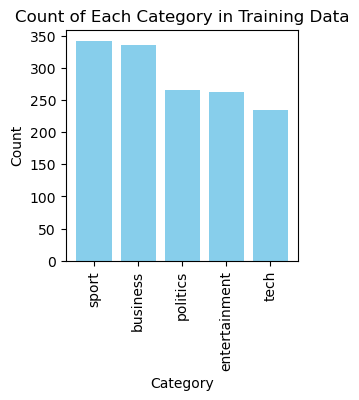

In [6]:
category_counts = train_df['Category'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

plt.figure(figsize=(3, 3))
plt.bar(category_counts.index, 
        category_counts.values, 
        color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category in Training Data')
plt.xticks(rotation=90)
plt.show()

### Vectorization:

In [7]:
text = train_df['Text']

# specify vectorizer
vectorizer = (TfidfVectorizer(max_features = 1000, 
                              stop_words='english'))
# vectorize text col
train_tfidf = vectorizer.fit_transform(text)
# feature names
feature_names = vectorizer.get_feature_names_out()



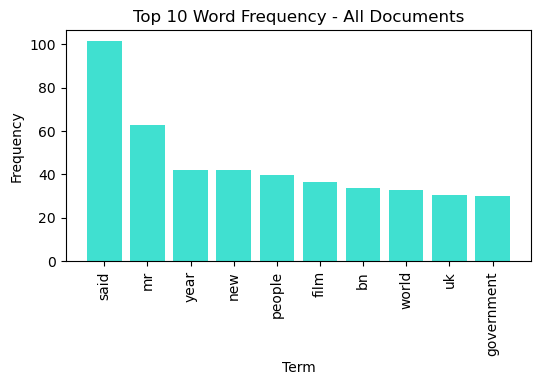

In [8]:
# word frequency - all documents
word_freq = np.sum(train_tfidf.toarray(), axis=0)
freq_all = pd.DataFrame({'Term': feature_names, 'Frequency': word_freq})
freq_all = freq_all.sort_values(by='Frequency', ascending=False)

# top 10 occurring
top_all = freq_all.head(10)

# word freq
plt.figure(figsize = (6, 3))
plt.bar(top_all['Term'], top_all['Frequency'], color='turquoise')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency - All Documents')
plt.tick_params(axis='x', rotation=90)

plt.show()

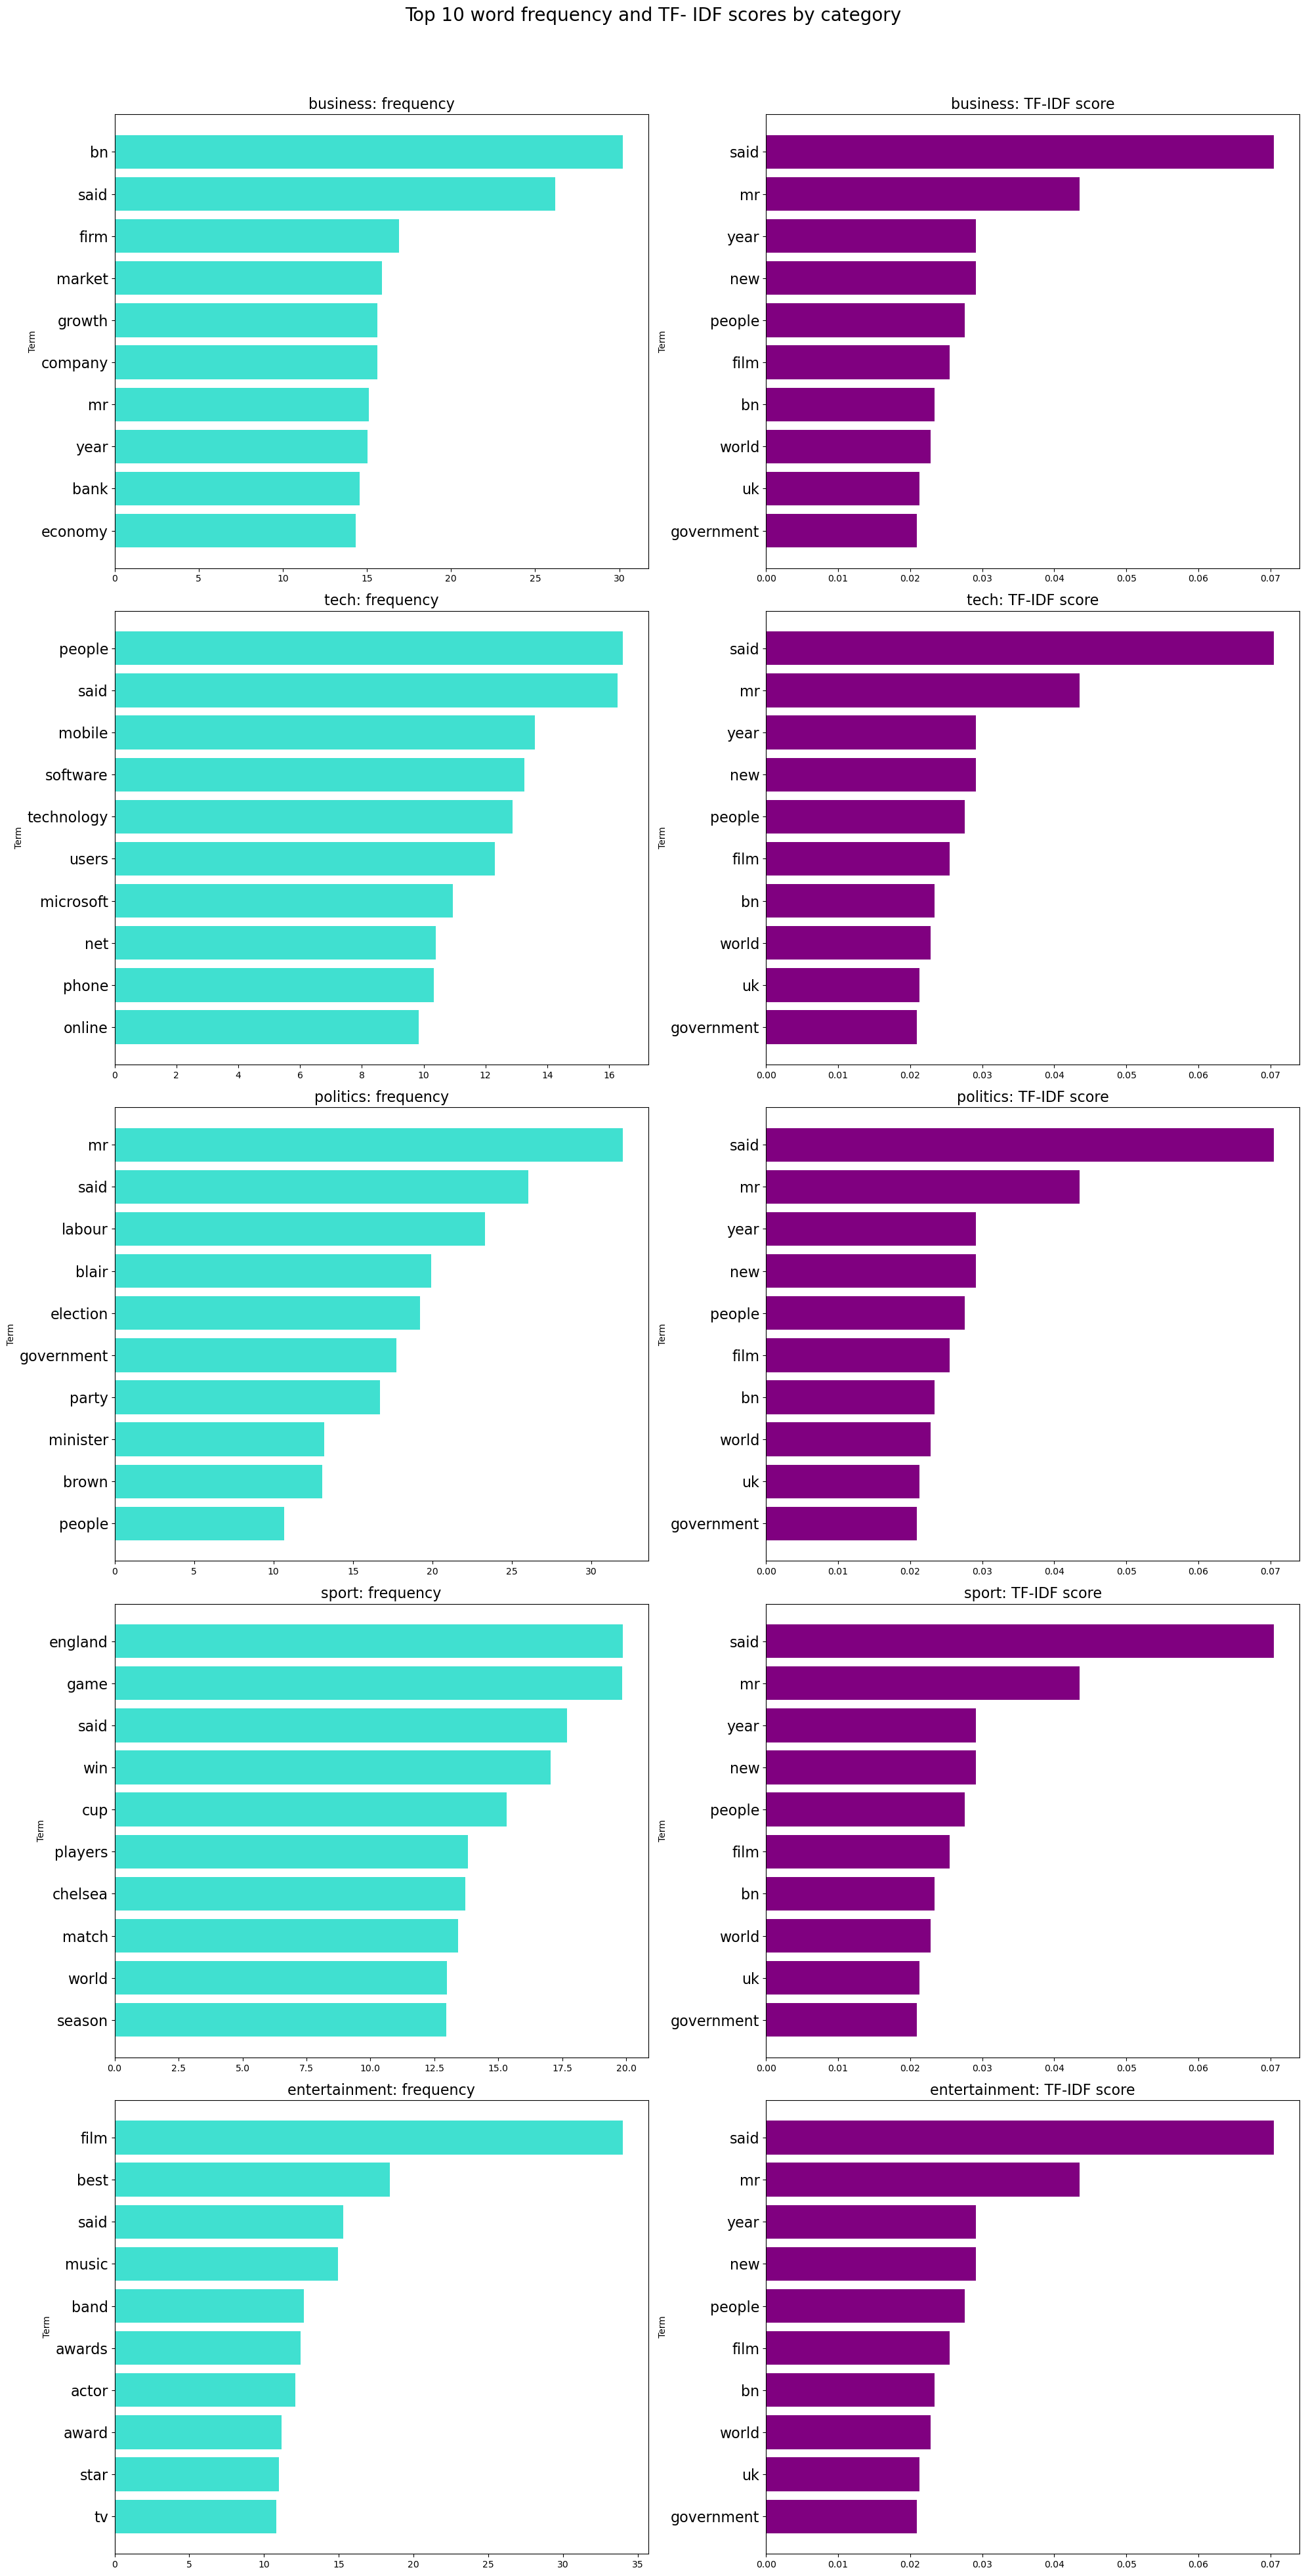

In [9]:
# subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 40))
fig.suptitle('Top 10 word frequency and TF- IDF scores by category', 
             fontsize = 20)

# word frequency - category
cat = train_df['Category'].unique()
#print(cat)

# loop to create subplots
for i, category in enumerate(cat):
    
    # filter train_tfidf for category
    cat_class = train_df['Category'] == category
    cat_tfidf = train_tfidf[cat_class]

    # word freq
    word_freq = np.sum(cat_tfidf.toarray(), 
                       axis = 0)
    freq_df = pd.DataFrame({'Term': feature_names,
                            'Frequency': word_freq})
    freq_df = freq_df.sort_values(by = 'Frequency', 
                                  ascending = False)
    # top10
    top_freq = freq_df.head(10)

    # left subplots, frequency
    ax_freq = axes[i, 0]
    ax_freq.barh(top_freq['Term'], 
           top_freq['Frequency'], 
           color='turquoise')
    ax_freq.set_title(f'{category}: frequency',
                      fontsize = 16 )
    #ax_freq.set_xlabel('Frequency')
    ax_freq.set_ylabel('Term')
    ax_freq.tick_params(axis = 'y', 
                        labelsize = 16)
    ax_freq.invert_yaxis()

    # tfidf scores
    tfidf_scores = np.mean(train_tfidf.toarray(), axis = 0)
    tfidf_all = pd.DataFrame({'Term': feature_names, 
                              'TF-IDF score': tfidf_scores})
    tfidf_all = tfidf_all.sort_values(by = 'TF-IDF score', 
                                      ascending = False)

    # top 10 scores
    top_tfidf = tfidf_all.head(10)
    
    # right subplots, scores
    ax_tfidf = axes[i, 1]
    ax_tfidf.barh(top_tfidf['Term'],
                  top_tfidf['TF-IDF score'],
                  color = 'purple')
    ax_tfidf.set_title(f'{category}: TF-IDF score', 
                       fontsize = 16)
    
    ax_tfidf.set_ylabel('Term')
    ax_tfidf.tick_params(axis = 'y', 
                         labelsize = 16)
    ax_tfidf.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### TF-IDF scores 

How important are these words in regards to the text? 
* The Tfidf scores tell us a word's importance in determining the category.
* How it works: The more frequent a word is in a document or article, the less important it becomes, therefor it's frequency has an inverse relationship to it's importance. An example of this in the data is the word 'said':
        *  'Said' is in the top 10 for all 5 categories. I suspect that it doesn't carry much meaning. 
* I'll use these scores to assist in dimensionality reduction.

### Modelling with dimensionality reduction

Now that I have some TF-IDF scores, I can use that to reduce the number of dimensions in the dataframe. I've found a few options for this:

* Truncated Single Value Decomposition (TruncatedSVD) - good for large, sparse TF-IDF matrices, but does not create a non-negative representation
* Principal Component Analysis (PCA) - good for variance-based reduction, but computationally expensive to convert the data to a dense matrix
* Non-negative Matrix Factorization (NMF) - preserves the non-negative representation of the data, This is the focus of week 4 in dtsa 5510, and the method I will use for modelling and dimension reduction. As there are 3 different options for the beta loss parameter, I'll iterate through two of them (Frobenius and Kullback-Leibler) to see which provides the best results. Itakura-Saito was giving me trouble, so I skipped that one.
    * To measure how well modelling with NMF works on this data, I will use the silhouette score (7). The sihouette score 'measures how well each data point fits into its assigned cluster. It combines information about both the cohesion (how close a data point is to other points in its own cluster) and the separation (how far a data point is from points in other clusters) of the data point'.
        * The sihouette score ranges from -1 to 1, with -1 indicating misclassification, 0 indicating overlapping clusters, and 1 indicating a good fit for the clusters or data points.
    * I will also use accuracy score from sklearn to assess the accuracy of the assigned topics.

In [10]:
type(train_tfidf)

scipy.sparse._csr.csr_matrix

* Silhouette score does not handle a sparse matrix. I need to convert it to a dense matrix.


Labels, when clustering, are assigned randomly. This means that the label may not match the ground truth label. We wrote a function to find the best matching label ordering based on accuracy in week 2 :)

In [11]:
# copied from my week 2 assignment
def label_permute_compare(ytdf, yp, n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """   
    perms = list(itertools.permutations(range(n)))
    acc=[]
    
    for perm in perms:        
        # map pred clustter labels to perm label
        permuted_labels = np.array([perm[label] for label in yp])
        accuracy = accuracy_score(ytdf, permuted_labels)
        acc.append(accuracy)
        
    # find best perm and accuracy    
    idx = np.argmax(acc)    
    best_permutation = perms[idx]
    best_accuracy = acc[idx]
    
    return best_permutation,best_accuracy 

##### Now to build a loop to iterate through the beta-loss solvers & different number of features for NMF and score the results.

In [12]:
# results
results_dict = {}

# tfidf results 
tfidf_results = {}

# text
text = train_df['Text']

# max number features
max_features_list = [500, 1000, 2000]

# loop - max feats to create different tfidf matrices
for max_features in max_features_list:
    
    # def vectorizer
    vectorizer = TfidfVectorizer(max_features = max_features, 
                                 stop_words='english')
    
    # fit transform
    train_tfidf = vectorizer.fit_transform(text)
    
    # feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Store the results in the dictionary
    tfidf_results[max_features] = {
        'tfidf_matrix': train_tfidf,
        'feature_names': feature_names
    }


# beta loss options & solvers
    beta_loss_solvers = {
        'frobenius': ('cd', 'nndsvd'),
        'kullback-leibler': ('mu', 'nndsvda')
    }    
     
# init nmf 
num_topics = 5  # because i know we have 5 categories
    
# loop - tfidf matrices from above 
for max_features, tfidf_data in tfidf_results.items():
    train_tfidf = tfidf_data['tfidf_matrix']
    feature_names = tfidf_data['feature_names']


    # loop - beta loss options
    for beta_loss, (solver, init) in beta_loss_solvers.items():
       
        # init nmf 
        nmf_model = NMF(n_components = num_topics, 
                        random_state = 5510, 
                        init = init,
                        beta_loss = beta_loss,
                        solver = solver,
                        tol = 1e-3,
                        max_iter = 200
                        )
        # start timer
        start_time = time.time()
    
        # fit
        W = nmf_model.fit_transform(train_tfidf)
        H = nmf_model.components_
    
        # pred cluster labels yp, mapo categories to numbers
        yp = np.argmax(W, axis=1)
        category_mapping = {category: i for i, category in enumerate(train_df['Category'].unique())}
        train_labels = train_df['Category'].map(category_mapping)
    
        # find best permutation
        best_permutation, best_accuracy = label_permute_compare(train_labels, yp, n=5)
        yp_permuted = np.array([best_permutation[label] for label in yp])
        
        # stop timer
        fit_time = time.time() - start_time
    
        # reduce dimensions adn normalize
        reduced_df = normalize(W)
        
        # silhouette_score
        if reduced_df.shape[1] > 1:
            silhouette_avg = silhouette_score(reduced_df,
                                              train_labels)
        else:
            silhouette_avg = None
    
        # store results
        results_dict[max_features,beta_loss] = {
            'solver': solver,
            'init': init,
            'mean_fit_time (s)': round(fit_time, 4),
            'silhouette_score': round(silhouette_avg, 4) if silhouette_avg is not None else 'N/A',
            'best_accuracy_after_permutation': round(best_accuracy, 4)  
        }
    
# results    
# Convert results dictionary to DataFrame
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

# Set multi-index from the keys of the dictionary
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['max_features', 'beta_loss'])

# Reset index if you want to have 'max_features' and 'beta_loss' as columns
results_df.reset_index(inplace=True)

# Rename columns
results_df.columns = (['max_features', 'beta_loss', 
                       'solver', 'init', 
                       'mean_fit_time (s)', 
                       'silhouette_score', 
                       'best_accuracy_after_permutation'])

results_df
    
    
    

,max_features,beta_loss,solver,init,mean_fit_time (s),silhouette_score,best_accuracy_after_permutation
0,500,frobenius,cd,nndsvd,0.0820,0.5209,0.8611
1,500,kullback-leibler,mu,nndsvda,0.2759,0.6585,0.9299
2,1000,frobenius,cd,nndsvd,0.0894,0.5665,0.8819
3,1000,kullback-leibler,mu,nndsvda,0.3390,0.6950,0.9431
4,2000,frobenius,cd,nndsvd,0.0930,0.5873,0.8958
5,2000,kullback-leibler,mu,nndsvda,0.4434,0.7175,0.9472


Here, we have silhouette scores that are all positive and closer to 1 than they are to 0, meaning that the data points are a decent (but not perfect) fit. According to the silhouette score, the KL loss function performed better overall than the Frobenius loss. As the number of max features increased, the sihouette scores also increased for both Frobenius and KL loss. (I realize that silhouette score is mainly used when we don't have ground-truth labels, but I wanted to include it anyways)

Now since we DO have ground truth labels and can compare the predicted labels to them, we can see that the KL loss yeilds better overall results than the Frobenius loss. As the number of max features increased, the best accuracy  also increased for both Frobenius and KL los..

### How does this clustering model perform on unseen data?

Given more time, I would create a pipeline. Alas, I skived off any school work for a whole week to read trashy novels, so it's copy/paste/change variable names for now.

In [13]:
# read in, concat testing data with sample solutions
df1 = pd.read_csv('data/BBC News Sample Solution.csv')
df2 = pd.read_csv('data/BBC News Test.csv')

test_df = pd.merge(df1, df2, on='ArticleId')

In [14]:
# clean testing data
test_df = remove_duplicates(test_df)
test_df['Text'] = test_df['Text'].apply(remove_non_alpha)
test_df.head(3)

No. of duplicate articles: 13



,ArticleId,Category,Text
0,1018,sport,qpr keeper day heads for preston queens park r...
1,1319,tech,software watching while you work software that...
2,1138,business,d arcy injury adds to ireland woe gordon d arc...


In [15]:
# vectorize
test_tfidf = vectorizer.transform(test_df['Text'])

# feature names
feature_names = vectorizer.get_feature_names_out()

In [16]:
# test results
test_results_dict = {}

# beta loss options & solvers
beta_loss_solvers = {
    'frobenius': ('cd', 'nndsvd'),
    'kullback-leibler': ('mu', 'nndsvda')
}

# init nmf 
num_topics = 5  # because i know we have 5 categories

# iterate through beta loss options
for beta_loss, (solver, init) in beta_loss_solvers.items():
   
    # init nmf 
    nmf_model = NMF(n_components = num_topics, 
                    random_state = 5510, 
                    init = init,
                    beta_loss = beta_loss,
                    solver = solver,
                    tol = 1e-3,
                    max_iter = 200
                    )
    # start timer
    start_time = time.time()

    # fit
    W = nmf_model.fit_transform(test_tfidf)
    H = nmf_model.components_

    # pred cluster labels yp, mapo categories to numbers
    yp = np.argmax(W, axis=1)
    category_mapping = {category: i for i, category in enumerate(test_df['Category'].unique())}
    test_labels = test_df['Category'].map(category_mapping)

    # find best permutation
    best_permutation, best_accuracy = label_permute_compare(test_labels, yp, n=5)
    yp_permuted = np.array([best_permutation[label] for label in yp])

    # stop timer
    fit_time = time.time() - start_time

    # reduce dimensions adn normalize
    reduced_df = normalize(W)
    
    # silhouette_score
    if reduced_df.shape[1] > 1:
        silhouette_avg = silhouette_score(reduced_df,
                                          test_labels)
    else:
        silhouette_avg = None
    
    # store results
    test_results_dict[beta_loss] = {
        'solver': solver,
        'init': init,
        'mean_fit_time (s)': round(fit_time, 4),
        'silhouette_score': round(silhouette_avg, 4) if silhouette_avg is not None else 'N/A',
        'best_accuracy_after_permutation': round(best_accuracy, 4)  
    }


test_results_df = pd.DataFrame(test_results_dict).T
test_results_df

,solver,init,mean_fit_time (s),silhouette_score,best_accuracy_after_permutation
frobenius,cd,nndsvd,0.075,-0.0245,0.2244
kullback-leibler,mu,nndsvda,0.2439,-0.0273,0.223


Well that's not very good at all. Both Frobenius and KL loss functions performed at an abyssmal 22.4% accuracy. This drastic change in model performance on the testing data is due to the NMF model being over-fit to the training data and it does not generalize well to other data.

### How does this clustering model compare to a supervised model?

In [17]:
# features and target
X = train_tfidf
y = train_df['Category']

# different test sizes
test_sizes = [0.1, 0.2, 0.5]

# define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=5510, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=5510),
    'K-Nearest Neighbors': KNeighborsClassifier()
    
}

# store overall results
overall_results = {}


# loop - test sizes
for test_size in test_sizes:

    # split
    X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                         test_size = test_size, 
                                                     random_state = 5510))
    # seupervised results dict
    supervised_results = {}

    # loop - classifiers
    for name, clf in classifiers.items():
    
        # fit
        clf.fit(X_train, y_train)
    
        # predict
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
    
        # accuracy
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
    
        # store results
        supervised_results[name] = {}
        supervised_results[name]['train_accuracy'] = train_accuracy
        supervised_results[name]['test_accuracy'] = test_accuracy
        supervised_results[name]['classification_report'] = (classification_report(y_test, 
                                                                                   y_pred_test, 
                                                                                   output_dict = True))
        supervised_results[name]['confusion_matrix'] = confusion_matrix(y_test, y_pred_test)
        
        # classification reprot & conf matrix
        report_df = pd.DataFrame(supervised_results[name]['classification_report']).T
        report_df.index.name = 'Class'
    
        # print(f"Classification report for {name} at test size {test_size*100}% as DataFrame:")
        # print(report_df)
        
    
        # plot
        # plt.figure(figsize = (8, 6))
        # sns.heatmap(supervised_results[name]['confusion_matrix'], 
        #              annot = True, 
        #              fmt = 'd', 
        #              cmap = 'Blues', 
        #              xticklabels = clf.classes_, 
        #              yticklabels = clf.classes_)
        # plt.title(f'Confusion Matrix for {name}')
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.show()
    
        # accuracies
        print(f"Training Accuracy ({name}) at test size {test_size*100}%: {train_accuracy:.4f}")
        print(f"Test Accuracy ({name}) at test size {test_size*100}%: {test_accuracy:.4f}")
        print("\n" + "-" * 50 + "\n")

    overall_results[test_size] = supervised_results
        

Training Accuracy (Logistic Regression) at test size 10.0%: 0.9954
Test Accuracy (Logistic Regression) at test size 10.0%: 0.9653

--------------------------------------------------

Training Accuracy (Random Forest) at test size 10.0%: 1.0000
Test Accuracy (Random Forest) at test size 10.0%: 0.9375

--------------------------------------------------

Training Accuracy (K-Nearest Neighbors) at test size 10.0%: 0.9606
Test Accuracy (K-Nearest Neighbors) at test size 10.0%: 0.9375

--------------------------------------------------

Training Accuracy (Logistic Regression) at test size 20.0%: 0.9948
Test Accuracy (Logistic Regression) at test size 20.0%: 0.9618

--------------------------------------------------

Training Accuracy (Random Forest) at test size 20.0%: 1.0000
Test Accuracy (Random Forest) at test size 20.0%: 0.9375

--------------------------------------------------

Training Accuracy (K-Nearest Neighbors) at test size 20.0%: 0.9601
Test Accuracy (K-Nearest Neighbors) at tes

## References:

1. **ChatGPT.** Damn rights, I used it and not going to pretend I didn't. There was a lot of back and forth, because nothing ever worked the first (or 5th) time around. AI is a tool, not a crutch. I suppose a crutch _IS_ a tool, but I digress.  **TLDR; I used AI for assistance, NOT to do the work for me.**    
      
2. [**This Kaggle notebook**](https://www.kaggle.com/code/cjtayl31772/mini-project-part-1) for guidance.

3. [**SKLearn TfidfVectorizer documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for reference.

4. [**geeksforgeeks.org**](https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/) for more guidance on TF-IDF

5. [**SKLearn NMF documentation**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) for reference.

6. All course lectures, notebooks, examples, readings, and material etc. were heavily referenced throughout this entire notebook.

7. [**Silhouette Score**](https://medium.com/@Suraj_Yadav/silhouette-coefficient-explained-with-a-practical-example-assessing-cluster-fit-c0bb3fdef719)